In [1]:
# Importing necessary libraries
import numpy as np
from matplotlib import pyplot as plt
import cv2

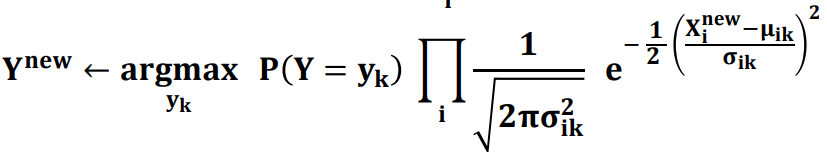

In [2]:
# Defining a gaussian naive bayes classifier for predictions. It uses the formula given above. For better calculation we use log.
class GaussianNB:
    
    # Class initialization
    def __init__(self):
        self.classes = np.array([0,1,2,3,4,5,6,7,8,9])
        self.parameters = None

    # Fitting the data to the model. Here we calculate parameters of the classifier which are 'means', 'variances' and 'priors'.
    # These parameters will be used to calculate likelihoods of test samples to predict the best label.
    def fit(self, X, y):
        self.parameters = {}

        for c in self.classes:
            X_c = X[y == c]
            self.parameters[c] = {
                "means": np.mean(X_c, axis=0),
                "variances": np.var(X_c, axis=0),
                "priors": X_c.shape[0] / X.shape[0]
            }
    
    # This method calculates the likelihood of the sample by using the parameters we calculated in fit method.
    def calc_likelihood(self, X, mean, var):
        return (-0.5 * np.sum(np.log(2. * np.pi * var))) - (0.5 * np.sum(((X - mean) ** 2) / (2 * var), 1))
    
    # This method calculates the posteriors of the sample for each class by using likelihood and prior.
    def calc_posteriors(self, X):
        posteriors= np.zeros((X.shape[0], len(self.classes)))

        for c in self.classes:
            params = self.parameters[c]
            posteriors[:, c] = self.calc_likelihood(X, params["means"], params["variances"]) + np.log(params["priors"])

        return posteriors
    
    # This method is used to predict the label of the samples. It returns the class label with the highest posterior.
    def predict(self, X):
        return self.classes[np.argmax(self.calc_posteriors(X), axis=1)]


In [3]:
# This method is used to calculate the accuracy of the predictions.
def accuracy(y_true, y_pred, layer):
    correct_predictions = np.sum(y_true == y_pred)
    total_samples = len(y_true)
    accuracy = correct_predictions / total_samples
    print(f"Accuracy for layer {layer} : {accuracy}")

In [4]:
# Loading given data
data = np.load("train_data.npy")
labels = np.load("train_labels.npy")
mask = np.load("train_mask.npy")
classes = np.load("classes.npy")

In [5]:
# Given image is a 16 bit image. Here I convert it to a 8 bit image to be able to plot it.
for i in range(6):
    data[:,:,i] = cv2.normalize(data[:,:,i], None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

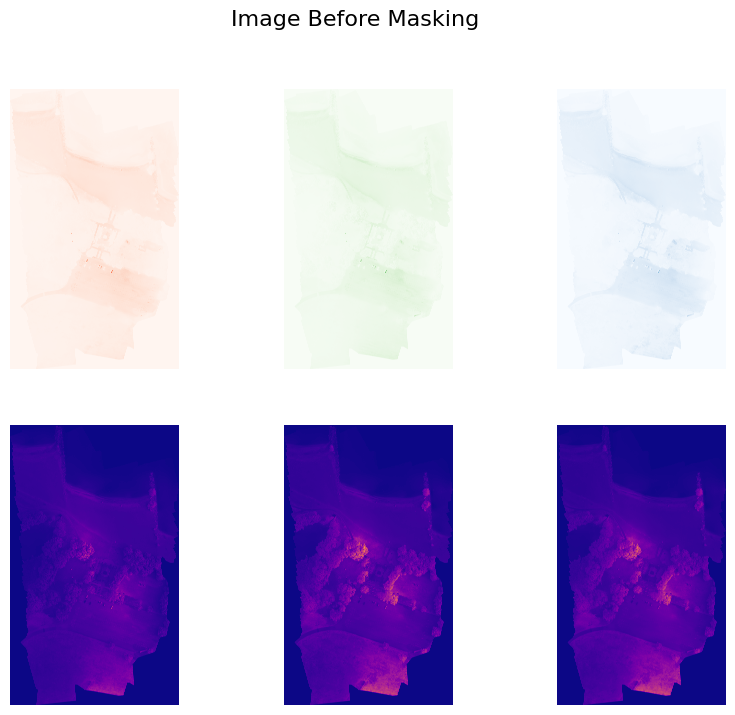

In [6]:
# Plotting the images before applying the mask.
fig, axs = plt.subplots(2, 3, figsize=(10, 8))

axs[0,0].imshow(data[:, :, 0], cmap="Reds")
axs[0,0].axis("off")

axs[0,1].imshow(data[:, :, 1], cmap="Greens")
axs[0,1].axis("off")

axs[0,2].imshow(data[:, :, 2], cmap="Blues")
axs[0,2].axis("off")

axs[1,0].imshow(data[:, :, 3], cmap="plasma")
axs[1,0].axis("off")

axs[1,1].imshow(data[:, :, 4], cmap="plasma")
axs[1,1].axis("off")

axs[1,2].imshow(data[:, :, 5], cmap="plasma")
axs[1,2].axis("off")

fig.suptitle('Image Before Masking', fontsize=16)
plt.show()

In [7]:
# Appling mask to dataset and labels.
labels = np.ma.masked_where(mask == 0, labels)
mask = np.tile(mask[:, :, np.newaxis], (1, 1, 6))
data = np.ma.masked_where(mask == 0, data)

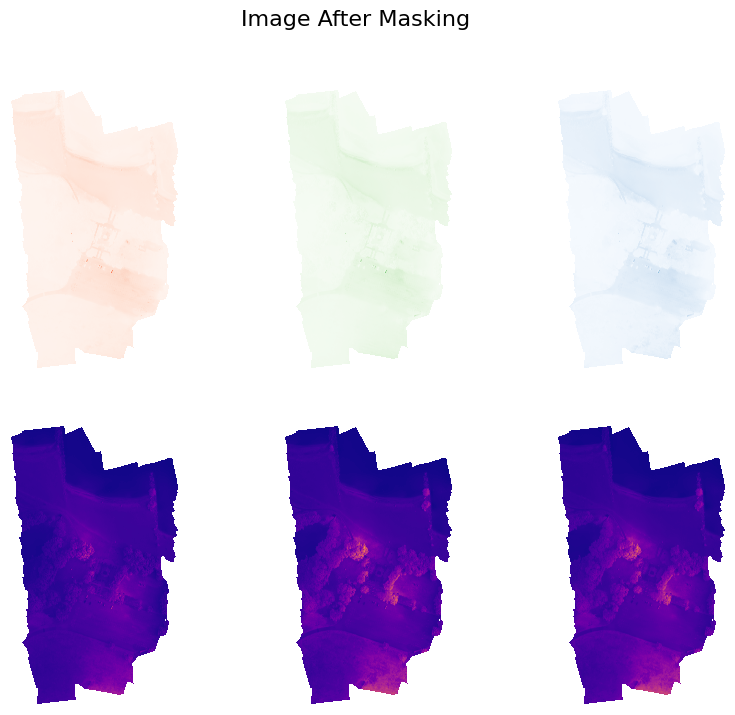

In [8]:
# Plotting the images after applying the mask.
fig, axs = plt.subplots(2, 3, figsize=(10, 8))

axs[0,0].imshow(data[:, :, 0], cmap="Reds")
axs[0,0].axis("off")

axs[0,1].imshow(data[:, :, 1], cmap="Greens")
axs[0,1].axis("off")

axs[0,2].imshow(data[:, :, 2], cmap="Blues")
axs[0,2].axis("off")

axs[1,0].imshow(data[:, :, 3], cmap="plasma")
axs[1,0].axis("off")

axs[1,1].imshow(data[:, :, 4], cmap="plasma")
axs[1,1].axis("off")

axs[1,2].imshow(data[:, :, 5], cmap="plasma")
axs[1,2].axis("off")

fig.suptitle('Image After Masking', fontsize=16)
plt.show()

In [9]:
# Splitting image into train and test by a ratio of 0.8.
slice_ratio = int(data.shape[1]*0.8)

trainX = data[:,:slice_ratio,:]
trainY = labels[:,:slice_ratio]
testX  = data[:,slice_ratio:,:]
testY  = labels[:,slice_ratio:]

In [10]:
labels[:,slice_ratio:].shape

(9393, 1129)

In [11]:
# Reshaping X matrix from 3D to 2D and Y matrix from 2D to 1D
trainX = trainX.reshape(-1, trainX.shape[-1])
testX = testX.reshape(-1, testX.shape[-1])
trainY = trainY.reshape(-1)
testY = testY.reshape(-1)

In [12]:
# Initializing the model
model = GaussianNB()

# A dict to store predictions
predictions = {}

# Performing classification for each layer
for i in range(6):
    model.fit(trainX[:,i:i+1], trainY)
    predictions[i] = model.predict(testX[:,i:i+1])
    accuracy(testY, predictions[i] , i)

# Performing classification for RGB layers
model.fit(trainX[:,0:3], trainY)
predictions["RGB"] = model.predict(testX[:,0:3])
accuracy(testY, predictions["RGB"], "RGB")

# Performing classification for Infrared layers
model.fit(trainX[:,3:6], trainY)
predictions["INFRA"] = model.predict(testX[:,3:6])
accuracy(testY, predictions["INFRA"], "INFRA")

# Performing classification for all layers
model.fit(trainX[:,0:6], trainY)
predictions["ALL"] = model.predict(testX[:,0:6])
accuracy(testY, predictions["ALL"], "ALL")



Accuracy for layer 0 : 0.23922239362425915
Accuracy for layer 1 : 0.16418649207987743
Accuracy for layer 2 : 0.16525988437010505
Accuracy for layer 3 : 0.3270498911944396
Accuracy for layer 4 : 0.37958896892575056
Accuracy for layer 5 : 0.37969184786703475
Accuracy for layer RGB : 0.18545536944619917
Accuracy for layer INFRA : 0.32147104250126146
Accuracy for layer ALL : 0.3883497095673738


As we can see from the accuracy scores of the predictions, our model performs best with an accuracy of 0.388 by using all the layers of the image. We see that we get the worst accuracy by using the green layer of the image with an accuracy of 0.164. Overall the model doesn't perform very well. This might be because of an imbalance of the classes or maybe the model isn't suitable for this machine learning problem at all. To better see the performance of the model we will plot the predicted labels with their true labels. We can also check the distribution of the classes to inspect the reason of poor performance of our model.

In [13]:
# Reshape the labels and predictions to its original form to plot the predictions.
G_labels = predictions[1].reshape((9393, 1129))
All_labels = predictions["ALL"].reshape((9393, 1129))
true_labels = np.copy(testY.reshape((9393, 1129)))

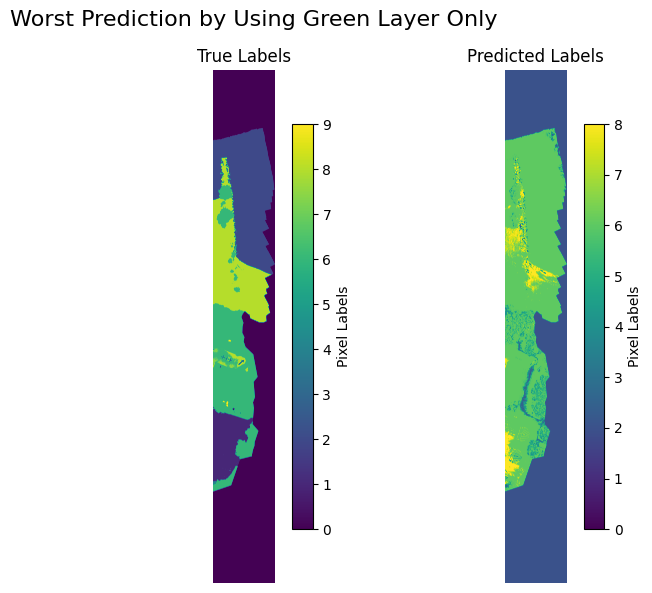

In [14]:
# Plotting the worst prediction we made.
fig, axs = plt.subplots(1, 2, figsize=(8, 6))

im1 = axs[0].imshow(true_labels, cmap="viridis")
axs[0].axis("off")
axs[0].set_title('True Labels')
cbar1 = fig.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04, orientation='vertical')
cbar1.set_label('Pixel Labels')

im2 = axs[1].imshow(G_labels, cmap="viridis")
axs[1].axis("off")
axs[1].set_title('Predicted Labels')
cbar2 = fig.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04, orientation='vertical')
cbar2.set_label('Pixel Labels')


fig.suptitle('Worst Prediction by Using Green Layer Only ', fontsize=16, ha='center')
fig.tight_layout()
plt.show()

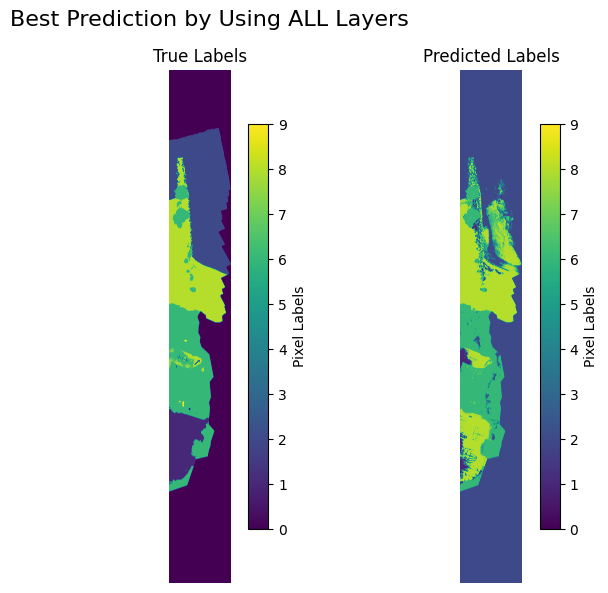

In [15]:
# Plotting the best prediction we made.
fig, axs = plt.subplots(1, 2, figsize=(8, 6))

im1 = axs[0].imshow(true_labels, cmap="viridis")
axs[0].axis("off")
axs[0].set_title('True Labels')
cbar1 = fig.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04, orientation='vertical')
cbar1.set_label('Pixel Labels')

im2 = axs[1].imshow(All_labels, cmap="viridis")
axs[1].axis("off")
axs[1].set_title('Predicted Labels')
cbar2 = fig.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04, orientation='vertical')
cbar2.set_label('Pixel Labels')


fig.suptitle('Best Prediction by Using ALL Layers ', fontsize=16, ha='center')
fig.tight_layout()
plt.show()

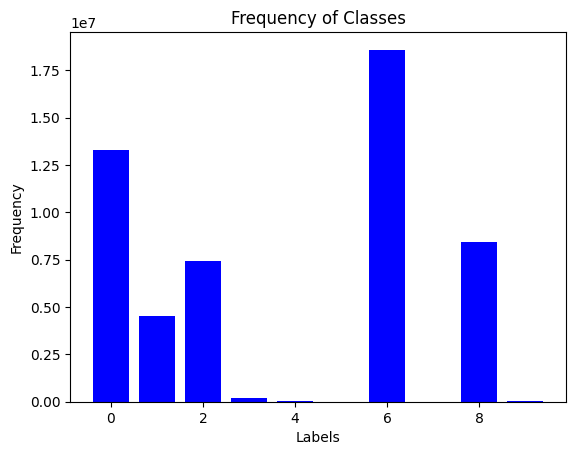

In [16]:
# Plot the frequency of each class
values, counts = np.unique(labels.reshape(-1), return_counts=True)

plt.bar(values, counts, color='blue')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Frequency of Classes')
plt.show()

From this barplot we can clearly see that there is a huge class imbalance problem for this image. As can be seen, the Gaussian Naive Bayes Classifier we use is quite weak to perform semantic segmentation of images, especially when there is a class imbalance problem. I think in such cases where a semantic segmentation is needed with a class imbalance data, we should use more advanced and complex algorithms to achieve better classifications.